# N-R Team
## E Navaneet Kumar, Rithvika Paladugu


- The `ratings.csv` file is prepared for machine learning models and consists of merged data from two different sources.
- The first source is `output1.txt`, originating from Parts 1 of Homeworks 5 and 6, which includes user and track identifiers, along with album and artist scores. This file contains 120,000 records.
- The second source is `test2_new.txt`, which provides the actual recommendation outcomes (ground truth) for 6,000 user-track pairs that are also present in `output1.txt`.

Now we will import all the necessary packages

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvf spark-3.5.1-bin-hadoop3.tgz
!pip install -q findspark

spark-3.5.1-bin-hadoop3/
spark-3.5.1-bin-hadoop3/sbin/
spark-3.5.1-bin-hadoop3/sbin/spark-config.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/start-workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-all.sh
spark-3.5.1-bin-hadoop3/sbin/stop-all.sh
spark-3.5.1-bin-hadoop3/sbin/workers.sh
spark-3.5.1-bin-hadoop3/sbin/start-mesos-dispatcher.sh
spark-3.5.1-bin-hadoop3/sbin/spark-daemon.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-worker.sh
spark-3.5.1-bin-hadoop3/sbin/slaves.sh
spark-3.5.1-bin-hadoop3/sbin/stop-mesos-shuffle-service.sh
spark-3.5.1-bin-hadoop3/sbin/stop-history-server.sh
spark-3.5.1-bin-hadoop3/sbin/stop-worker.sh
spark-3.5.1-bin-hadoop3/sbin/decommission-slave.sh
spark-3.5.1-bin-hadoop3/sbin/stop-thriftserver.sh
spark-3.5.1-bin-hadoop3/sbin/start-worker.sh
spark-3.5.1-bin-hadoop3/sbin/stop-slaves.sh
spark-3.5.1-bin-hadoop3/sbin/start-connect-server.sh


In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

In [ ]:
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession    # main entry point for DataFrame and SQL functionality
from pyspark.sql.functions import col    # for returning a column based on a given column name
from pyspark.sql.functions import lit    # for adding a new column to PySpark DataFrame
from pyspark.ml.classification import LogisticRegression    # for classification model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler    # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator    # for evaluating classification models
from pyspark.ml import Pipeline
import pandas as pd   # for data frames
import numpy as np    # for arrays
import time           # for timing cells
import matplotlib.pyplot as plt # plotting graphs

In [ ]:
spark = SparkSession.builder.appName('HW9_N-R Team').getOrCreate()

In [ ]:
spark

In [ ]:
ground_truth_columns = ['userID', 'trackID', 'ground_truth']

In [ ]:
ground_truth_df = pd.read_csv('test2_new.txt', sep='|', names=ground_truth_columns)

In [ ]:
ground_truth_df

,userID,trackID,ground_truth
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1
...,...,...,...
5995,212234,137371,0
5996,212234,42375,0
5997,212234,277867,1
5998,212234,83093,1



- We started by specifying the column names for the dataset as 'userID', 'trackID', and 'ground_truth'. These columns correspond to the unique identifiers for users and tracks, and a truth value indicating if a track was liked.

- Next, we loaded the data from 'test2_new.txt' into a DataFrame. This text file is structured with each piece of data separated by a pipe ('|'), which then indicated to Pandas using the `sep='|'` parameter.

- We named the DataFrame `ground_truth_df` to reflect that it contains the ground truth data for the recommendation system.

- Finally, to ensure the data loaded correctly, We displayed the DataFrame which would show the top rows by default, giving me a quick snapshot of the data structure.

In [ ]:
scores_columns = ['userID', 'trackID', 'album_score', 'artist_score']

In [ ]:
scores_df = pd.read_csv('output1.txt', sep='|', names=scores_columns)

In [ ]:
scores_df

,userID,trackID,album_score,artist_score
0,199810,208019,0.0,0.0
1,199810,74139,0.0,0.0
2,199810,9903,0.0,0.0
3,199810,242681,0.0,0.0
4,199810,18515,0.0,70.0
...,...,...,...,...
119995,249010,72192,0.0,0.0
119996,249010,86104,0.0,0.0
119997,249010,186634,90.0,90.0
119998,249010,293818,0.0,0.0


In [ ]:
ratings_df = ground_truth_df.merge(scores_df, on=['userID', 'trackID']).fillna(0)    # inner join by default

In [ ]:
ratings_df

,userID,trackID,ground_truth,album_score,artist_score
0,200031,30877,1,90.0,50.0
1,200031,8244,1,90.0,0.0
2,200031,130183,0,0.0,0.0
3,200031,198762,0,0.0,0.0
4,200031,34503,1,90.0,50.0
...,...,...,...,...,...
5995,212234,137371,0,0.0,0.0
5996,212234,42375,0,0.0,0.0
5997,212234,277867,1,90.0,90.0
5998,212234,83093,1,90.0,90.0


- Combined the ground truth data with the scores data into a single DataFrame called `ratings_df`. This was done by matching each user and track pair from `ground_truth_df` and `scores_df` on their 'userID' and 'trackID' columns.

- The `merge` function performs an inner join by default, which means only user-track pairs present in both DataFrames are included in the resulting `ratings_df`.

- After merging, I used the `fillna(0)` method to replace any missing values that might have appeared during the merge with zeros.

- Lastly, displayed `ratings_df`.This will give us a 6,000 line DF that contains the scores and ground truths.**bold text**

Finally we write this to a csv file.

## Next

We will prepare the `ratings.csv` for various machine learning classification models.

- Initially, we converted the `ratings.csv` into a Spark DataFrame. This transformation is crucial as it allows for the utilization of Spark's powerful distributed data processing capabilities, which are particularly effective for handling machine learning tasks on large datasets.

In [ ]:
ratings_df.to_csv('ratings.csv', index=None)

In [ ]:
ratings_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)

In [ ]:
ratings_df

DataFrame[userID: int, trackID: int, ground_truth: int, album_score: double, artist_score: double]

In [ ]:
ratings_df.count()

6000

In [ ]:
ratings_columns = ratings_df.columns

In [ ]:
pd.DataFrame(ratings_df.take(6000), columns=ratings_columns).groupby('ground_truth').count()

,userID,trackID,album_score,artist_score
ground_truth,,,,
0,3000,3000,3000,3000
1,3000,3000,3000,3000


In [ ]:
ratings_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



After converting the `ratings.csv` file into a Spark DataFrame, we checked the schema of the DataFrame using the `printSchema()` method. This allowed us to confirm that the DataFrame was structured correctly, with the appropriate data types assigned to each column:

- `userID`: an integer column, representing the unique identifier for users.
- `trackID`: an integer column, representing the unique identifier for tracks.
- `ground_truth`: an integer column, indicating whether the track was liked by the user.
- `album_score`: a double column, representing the score of the album associated with the track.
- `artist_score`: a double column, representing the score of the artist associated with the track.

Each of these columns is set to allow null values (`nullable = true`), which is standard in data schemas to accommodate missing entries.

In [ ]:
ratings_df = ratings_df.withColumn('ground_truth', ratings_df['ground_truth'].cast('string'))

 Converted the `ground_truth` column in the `ratings_df` DataFrame from integers to strings. This step is essential because the `StringIndexer()` method, which I plan to use later, requires the input column to be in string format. This conversion ensures that the DataFrame meets the prerequisites for applying the `StringIndexer()`.

In [ ]:
ratings_df.dtypes

[('userID', 'int'),
 ('trackID', 'int'),
 ('ground_truth', 'string'),
 ('album_score', 'double'),
 ('artist_score', 'double')]

Then utilized the `VectorAssembler()` function to transform and merge multiple numeric columns into a single vector column. This is a crucial step for preparing the data for machine learning models, as it consolidates the features into a format that the algorithms can process effectively.

In [ ]:
feature_columns = ['album_score', 'artist_score']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [ ]:
label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [ ]:
pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(ratings_df)        # fit the pipeline model
train_df = pipeline_model.transform(ratings_df)  # transform the input DF with the pipeline model

- **Initializing the Pipeline**: We created a `Pipeline` object and specified its `stages`, which includes all the transformations I planned (like `StringIndexer` and `VectorAssembler`). This organizes the steps in a sequence that will be executed in order.

- **Fitting the Pipeline**: Next, we fit the pipeline to the `ratings_df`. This step involves the pipeline learning from the data, essentially training on the DataFrame to understand the transformations specified in its stages.

- **Transforming the Data**: After fitting, used the trained pipeline model to transform `ratings_df`. This applies all the transformations defined in the pipeline to the data, outputting a new DataFrame, `train_df`, which is now ready for machine learning models with all features properly encoded and assembled.

In [ ]:
selected_columns = ['label', 'features'] + ratings_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: string (nullable = true)
 |-- album_score: double (nullable = true)
 |-- artist_score: double (nullable = true)



We've successfully added two new columns to our DataFrame:

- `label`: This column, of type double, stores the labels that our machine learning models will predict.
- `features`: A vector column that encapsulates all the features needed for modeling.

Next, we'll display the first five rows of this updated DataFrame.

In [ ]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0]","[90.0, 0.0]","(0.0, 0.0)","(0.0, 0.0)","[90.0, 50.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90.0,90.0,0.0,0.0,90.0
artist_score,50.0,0.0,0.0,0.0,50.0


Now we split the data into training data and testing data with a 70:30 split.

In [ ]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2018)

In [ ]:
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4260
Test Dataset Count: 1740


Next, we'll load the `output1.txt` file, which contains 120,000 entries that we need to predict using our models. Similar to the earlier steps, w'll set up the pipeline to process this data, ensuring that each entry is formatted correctly with labels and features columns, ready for the prediction phase.

In [ ]:
prediction_df = spark.read.csv('output1.txt', sep='|', inferSchema=True)

In [ ]:
prediction_df.count()

120000

In [ ]:
prediction_df = prediction_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore")

In [ ]:
prediction_columns = prediction_df.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore']

In [ ]:
prediction_df = prediction_df.withColumn('prediction', lit('0'))

In [ ]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0
prediction,0,0,0,0,0


In [ ]:
prediction_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)
 |-- prediction: string (nullable = false)



In [ ]:
feature_columns = ['albumScore', 'artistScore']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [ ]:
label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [ ]:
prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction_df)  # fit the pipeline model
prediction_df = prediction_pipeline_model.transform(prediction_df)  # transform the input DF with the pipeline model

In [ ]:
selected_columns = ['label', 'features'] + prediction_columns
prediction_df = prediction_df.select(selected_columns)
prediction_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: double (nullable = true)
 |-- artistScore: double (nullable = true)



In [ ]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","(0.0, 0.0)","[0.0, 70.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0.0,0.0,0.0,0.0,0.0
artistScore,0.0,0.0,0.0,0.0,70.0


# Model 1 - Logistic Regression

In [ ]:
from pyspark.ml.classification import LogisticRegression

In [ ]:
start_time = time.time()

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)  # initialize a logistic regression model
lr_model = lr.fit(train_df)                                                         # fit the training data with the model

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 4.75 seconds.


In [ ]:
lr_model.coefficients

DenseVector([0.0452, 0.0326])

In [ ]:
beta = np.sort(lr_model.coefficients)

In [ ]:
beta

array([0.03256793, 0.04519982])

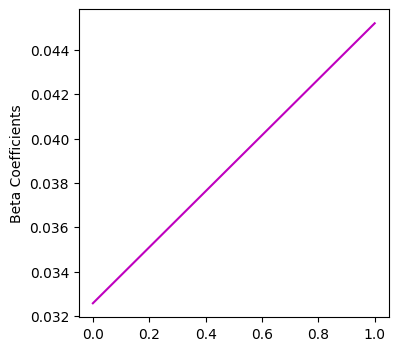

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(beta, color="m")
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
training_summary = lr_model.summary

In [ ]:
roc = training_summary.roc.toPandas()

In [ ]:
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.039683
2,0.000000,0.040149
3,0.000000,0.040616
4,0.000000,0.041083
...,...,...
88,0.076015,0.783847
89,0.076487,0.783847
90,0.076959,0.783847
91,1.000000,1.000000


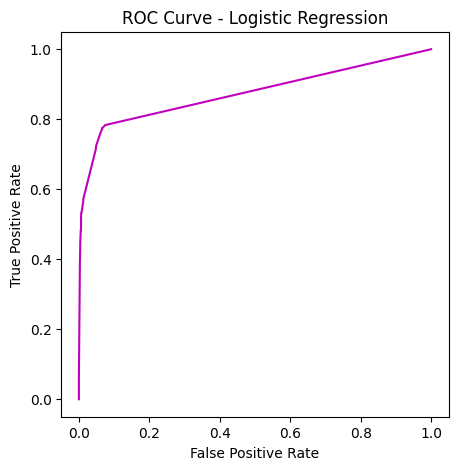

Training Set AUC = 0.8737133978552075


In [ ]:
plt.figure(figsize=(5, 5))
plt.plot(roc.FPR, roc.TPR, color= "m")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()
print(f'Training Set AUC = {training_summary.areaUnderROC}')

We achieved pretty good results with a Training Set AUC of 0.8737133978552075, indicating strong predictive performance of our model.

In [ ]:
predictions = lr_model.transform(test_df)
predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').show(20)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 124239|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 271459|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200085| 134106|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200099|  41892|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200106| 152491|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200124| 284066|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200143| 131171|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200143| 187136|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200160| 231

In [ ]:

sort_predictions = predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions.show()

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200031|   8244|  1.0|[0.06488875729218...|[-2.6679911209111...|       1.0|
|200031|  30877|  1.0|[0.01343471003408...|[-4.2963878477543...|       1.0|
|200055|  56695|  1.0|[0.00368752576332...|[-5.5991052292289...|       1.0|
|200065| 179571|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200065| 119451|  1.0|[0.17782970128751...|[-1.5311211916575...|       1.0|
|200065|  26875|  1.0|[0.00368752576332...|[-5.5991052292289...|       1.0|
|200070| 124239|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200070| 271459|  0.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200074| 289311|  1.0|[0.80218276453714...|[1.39999291666030...|       0.0|
|200085| 134

In [ ]:
logistic_predictions = lr_model.transform(prediction_df)    # transform prediction_df with logistic regression model
logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
|199812| 276940|[0.80218276453714...|[1.39999291666030...|       0.0|
|199812| 142408|[0.00169769820591...|[-6.3767828009944...|       1.0|
|199812| 130023|[0.00169769820591...|[-6.3767828009944...|       1.0|
|199812|  29189|[0.80218276453714...|[1.39999291666030...|       0.0|
|199812| 223706|[0.13507641145138...|[-1.8568005370262...|       1.0|
|199812| 211361|[0.8

In [ ]:

sort_logistic_predictions = logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  74139|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|   9903|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810| 242681|[0.80218276453714...|[1.39999291666030...|       0.0|
|199810|  18515|[0.29322699696820...|[-0.8797625009202...|       1.0|
|199810| 105760|[0.17782970128751...|[-1.5311211916575...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
pd_sort_logistic_predictions = sort_logistic_predictions.toPandas().fillna(0.0)

In [ ]:
pd_sort_logistic_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
1,199810,74139,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
2,199810,9903,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
3,199810,242681,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
4,199810,18515,"[0.2932269969682032, 0.7067730030317968]","[-0.8797625009202483, 0.8797625009202483]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
119996,249010,293818,"[0.8021827645371431, 0.1978172354628569]","[1.3999929166603091, -1.3999929166603091]",0.0
119997,249010,110470,"[0.003687525763326008, 0.996312474236674]","[-5.599105229228973, 5.599105229228973]",1.0
119998,249010,186634,"[0.003687525763326008, 0.996312474236674]","[-5.599105229228973, 5.599105229228973]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_logistic_predictions.to_csv('lr_predictions.csv', index=False, header=None, columns=columns_to_write)

In [ ]:
f_lr_predictions = open('lr_predictions.csv')
f_lr_final_predictions = open('lr_final_predictions.csv', 'w')

In [ ]:

f_lr_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:

last_user_id = -1
track_id_out_vec = [0] * 6

In [ ]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_lr_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_lr_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.27 seconds.


In [ ]:
f_lr_predictions.close()
f_lr_final_predictions.close()

# Model 2 - Gradient-Boosted Tree Classifier

In [ ]:
from pyspark.ml.classification import GBTClassifier

In [ ]:
start_time = time.time()

gbt = GBTClassifier(maxIter=100)
gbt_model = gbt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 37.10 seconds.


In [ ]:
predictions_gbt = gbt_model.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_gbt)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [ ]:
sort_predictions_gbt = predictions_gbt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_gbt.show(5)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
|200031|  30877|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200031|   8244|  1.0|[0.01165681655269...|[-2.2200694341913...|       1.0|
|200055|  56695|  1.0|[0.01632026531261...|[-2.0494463824457...|       1.0|
|200065| 179571|  0.0|[0.80853359039673...|[0.72025491912707...|       0.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
gbt_predictions = gbt_model.transform(prediction_df)    # transform prediction_df with gradient-boosted tree model
gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(10)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
|199810| 105760|[0.19777096337535...|[-0.7001422692047...|       1.0|
|199812| 276940|[0.80853359039673...|[0.72025491912707...|       0.0|
|199812| 142408|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812| 130023|[0.01161609118736...|[-2.2218399428711...|       1.0|
|199812|  29189|[0.80853359039673...|[0.72025491912707...|       0.0|
+------+-------+--------------------+--------------------+----------+
only showing top 10 

In [ ]:

sort_gbt_predictions = gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gbt_predictions.show(5)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  74139|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|   9903|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810| 242681|[0.80853359039673...|[0.72025491912707...|       0.0|
|199810|  18515|[0.24633418901301...|[-0.5591299711568...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 5 rows



In [ ]:
pd_sort_gbt_predictions = sort_gbt_predictions.toPandas().fillna(0.0)

In [ ]:
pd_sort_gbt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270775, -0.7202549191270775]",0.0
1,199810,74139,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270775, -0.7202549191270775]",0.0
2,199810,9903,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270775, -0.7202549191270775]",0.0
3,199810,242681,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270775, -0.7202549191270775]",0.0
4,199810,18515,"[0.24633418901301743, 0.7536658109869826]","[-0.5591299711568518, 0.5591299711568518]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270775, -0.7202549191270775]",0.0
119996,249010,293818,"[0.8085335903967381, 0.1914664096032619]","[0.7202549191270775, -0.7202549191270775]",0.0
119997,249010,110470,"[0.0163202653126165, 0.9836797346873835]","[-2.0494463824457227, 2.0494463824457227]",1.0
119998,249010,186634,"[0.0163202653126165, 0.9836797346873835]","[-2.0494463824457227, 2.0494463824457227]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_gbt_predictions.to_csv('gbt_predictions.csv', index=False, header=None, columns=columns_to_write)

In [ ]:
f_gbt_predictions = open('gbt_predictions.csv')
f_gbt_final_predictions = open('gbt_final_predictions.csv', 'w')

In [ ]:

f_gbt_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [ ]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_gbt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_gbt_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.29 seconds.


In [ ]:
f_gbt_predictions.close()
f_gbt_final_predictions.close()

# Model 3 - Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier

In [ ]:
start_time = time.time()

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=3)
dt_model = dt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.74 seconds.


In [ ]:
predictions_dt = dt_model.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_dt)    # evaluate decision tree model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [ ]:
sort_predictions_dt = predictions_dt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_dt.show(5)

+------+-------+-----+--------------------+--------------+----------+
|userID|trackID|label|         probability| rawPrediction|prediction|
+------+-------+-----+--------------------+--------------+----------+
|200031| 130183|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
|200031|  30877|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200031|   8244|  1.0|[0.01470588235294...|    [1.0,67.0]|       1.0|
|200055|  56695|  1.0|[0.08880090497737...|[157.0,1611.0]|       1.0|
|200065| 179571|  0.0|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+-----+--------------------+--------------+----------+
only showing top 5 rows



In [ ]:
dt_predictions = dt_model.transform(prediction_df)    # transform prediction_df with decision tree model
dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(10)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+--------------+----------+
only showing top 10 rows



In [ ]:

sort_dt_predictions = dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_dt_predictions.show(5)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 5 rows



In [ ]:
pd_sort_dt_predictions = sort_dt_predictions.toPandas().fillna(0.0)

In [ ]:
pd_sort_dt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_dt_predictions.to_csv('dt_predictions.csv', index=False, header=None, columns=columns_to_write)

In [ ]:
f_dt_predictions = open('dt_predictions.csv')
f_dt_final_predictions = open('dt_final_predictions.csv', 'w')

In [ ]:

f_dt_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [ ]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_dt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_dt_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.27 seconds.


In [ ]:
f_dt_predictions.close()
f_dt_final_predictions.close()

# Model 4 - Random Forest Classifier

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
start_time = time.time()

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 2.20 seconds.


In [ ]:
predictions_rf = rf_model.transform(test_df)

In [ ]:
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_rf)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 14.48%


In [ ]:
sort_predictions_rf = predictions_rf.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_rf.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 130183|  0.0|[0.80809388591375...|[16.1618777182750...|       0.0|
|200031|  30877|  1.0|[0.02845040162389...|[0.56900803247793...|       1.0|
|200031|   8244|  1.0|[0.00847380746267...|[0.16947614925344...|       1.0|
|200055|  56695|  1.0|[0.01412590057019...|[0.28251801140389...|       1.0|
|200065| 179571|  0.0|[0.80809388591375...|[16.1618777182750...|       0.0|
|200065| 119451|  1.0|[0.19067347143701...|[3.81346942874023...|       1.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
rf_predictions = dt_model.transform(prediction_df)    # transform prediction_df with random forest model
rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 276940|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 142408|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 130023|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812|  29189|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199812| 223706|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199812| 211361|[0.80858085808580...|[1960.0,464.0]|       0.0|
+------+-------+--------------------+---

In [ ]:

sort_rf_predictions = rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_rf_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  74139|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|   9903|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810| 242681|[0.80858085808580...|[1960.0,464.0]|       0.0|
|199810|  18515|[0.08880090497737...|[157.0,1611.0]|       1.0|
|199810| 105760|[0.08880090497737...|[157.0,1611.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [ ]:
pd_sort_rf_predictions = sort_rf_predictions.toPandas().fillna(0.0)

In [ ]:
pd_sort_rf_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
1,199810,74139,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
2,199810,9903,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
3,199810,242681,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
4,199810,18515,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119996,249010,293818,"[0.8085808580858086, 0.19141914191419143]","[1960.0, 464.0]",0.0
119997,249010,110470,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0
119998,249010,186634,"[0.08880090497737557, 0.9111990950226244]","[157.0, 1611.0]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_rf_predictions.to_csv('rf_predictions.csv', index=False, header=None, columns=columns_to_write)

In [ ]:
f_rf_predictions = open('rf_predictions.csv')
f_rf_final_predictions = open('rf_final_predictions.csv', 'w')

In [ ]:

f_rf_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

In [ ]:
start_time = time.time()

# Go through each line of the predictions file
for line in f_rf_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_rf_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 0.27 seconds.


In [ ]:
f_dt_predictions.close()
f_dt_final_predictions.close()

# ***Summary***

Based on the Kaggle results we submitted, here's a breakdown of how each of the four machine learning classification models we implemented performed:

- **Logistic Regression**: This model provided the highest score among the classifiers, with an accuracy of 0.845. This suggests that the logistic regression model was quite effective at capturing the linear relationships between the features and the target variable.

- **Decision Tree**: The decision tree model achieved an accuracy of 0.823. While it performed decently, it was slightly less effective compared to logistic regression. Decision trees are typically good at handling complex datasets with non-linear relationships, but they might overfit if not properly tuned.

- **Random Forest**: This model also scored 0.823, tying with the decision tree. Random forests, an ensemble method that uses multiple decision trees, usually provide better generalization compared to a single decision tree. The identical score to the decision tree suggests that in this particular case, the ensemble effect did not significantly enhance the predictive accuracy, which could be due to the nature of the data or model parameters.

- **Gradient-Boosted Tree**: Nearly matching logistic regression, this model scored 0.844. Gradient boosting is another ensemble technique that builds trees sequentially, each new tree correcting errors made by previously trained trees. Its performance here indicates a strong capability, nearly matching the simpler logistic regression, which emphasizes its efficiency in handling different types of data distributions and complexities.

In [ ]:
from pyspark.sql import SparkSession    # main entry point for DataFrame and SQL functionality
from pyspark.sql.functions import col    # for returning a column based on a given column name
from pyspark.sql.functions import lit    # for adding a new column to PySpark DataFrame
from pyspark.ml.classification import LogisticRegression    # for classification model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler    # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator    # for evaluating classification models
from pyspark.ml import Pipeline
import pandas as pd   # for data frames
import numpy as np    # for arrays
import time           # for timing cells
import matplotlib.pyplot as plt # plotting graphs

In [ ]:
spark = SparkSession.builder.appName('Logistic_Regression').getOrCreate()
spark

In [ ]:
ground_truth_columns = ['userID', 'trackID', 'ground_truth']
ground_truth_df = pd.read_csv('test2_new.txt', sep='|', names=ground_truth_columns)
ground_truth_df

,userID,trackID,ground_truth
0,200031,30877,1
1,200031,8244,1
2,200031,130183,0
3,200031,198762,0
4,200031,34503,1
...,...,...,...
5995,212234,137371,0
5996,212234,42375,0
5997,212234,277867,1
5998,212234,83093,1


In [ ]:
scores_columns = ['userID', 'trackID', 'album_score', 'artist_score', 'genre_score']
scores_df = pd.read_csv('genre_test.txt', sep='|', names=scores_columns)
scores_df

,userID,trackID,album_score,artist_score,genre_score
0,199810,208019,0,0,0.0
1,199810,74139,0,0,80.0
2,199810,9903,0,0,0.0
3,199810,242681,0,0,0.0
4,199810,18515,0,70,0.0
...,...,...,...,...,...
119995,249010,72192,0,0,0.0
119996,249010,86104,0,0,0.0
119997,249010,186634,90,90,0.0
119998,249010,293818,0,0,0.0


In [ ]:
ratings_df = ground_truth_df.merge(scores_df, on=['userID', 'trackID']).fillna(0)    # inner join by default
ratings_df

,userID,trackID,ground_truth,album_score,artist_score,genre_score
0,200031,30877,1,90,50,85.0
1,200031,8244,1,90,0,85.0
2,200031,130183,0,0,0,0.0
3,200031,198762,0,0,0,90.0
4,200031,34503,1,90,50,85.0
...,...,...,...,...,...,...
5995,212234,137371,0,0,0,0.0
5996,212234,42375,0,0,0,0.0
5997,212234,277867,1,90,90,0.0
5998,212234,83093,1,90,90,0.0


In [ ]:
ratings_df.to_csv('ratings.csv', index=None)    # index=None means index column is not written to csv

In [ ]:
ratings_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)    # inferSchema scans csv twice to get datatype of each column
ratings_df
ratings_df.count()
ratings_columns = ratings_df.columns
pd.DataFrame(ratings_df.take(6000), columns=ratings_columns).groupby('ground_truth').count()

,userID,trackID,album_score,artist_score,genre_score
ground_truth,,,,,
0,3000,3000,3000,3000,3000
1,3000,3000,3000,3000,3000


In [ ]:
ratings_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: integer (nullable = true)
 |-- artist_score: integer (nullable = true)
 |-- genre_score: double (nullable = true)



In [ ]:
ratings_df = ratings_df.withColumn('ground_truth', ratings_df['ground_truth'].cast('string'))
ratings_df.dtypes

[('userID', 'int'),
 ('trackID', 'int'),
 ('ground_truth', 'string'),
 ('album_score', 'int'),
 ('artist_score', 'int'),
 ('genre_score', 'double')]

In [ ]:
feature_columns = ['album_score', 'artist_score', 'genre_score']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

In [ ]:
label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

In [ ]:
pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(ratings_df)        # fit the pipeline model
train_df = pipeline_model.transform(ratings_df)  # transform the input DF with the pipeline model

selected_columns = ['label', 'features'] + ratings_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: string (nullable = true)
 |-- album_score: integer (nullable = true)
 |-- artist_score: integer (nullable = true)
 |-- genre_score: double (nullable = true)



In [ ]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0, 85.0]","[90.0, 0.0, 85.0]","(0.0, 0.0, 0.0)","[0.0, 0.0, 90.0]","[90.0, 50.0, 85.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90,90,0,0,90
artist_score,50,0,0,0,50
genre_score,85.0,85.0,0.0,90.0,85.0


In [ ]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2021)
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4194
Test Dataset Count: 1806


In [ ]:
#Load in and prepare prediction file

prediction_df = spark.read.csv('genre_test.txt', sep='|', inferSchema=True)    # inferSchema scans csv twice to get datatype of each column
prediction_df.count()

120000

In [ ]:
prediction_df = prediction_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore").withColumnRenamed("_c4", "genreScore")
prediction_columns = prediction_df.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore', 'genreScore']

In [ ]:
prediction_df = prediction_df.withColumn('prediction', lit('0'))
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0,0,0,0,0
artistScore,0,0,0,0,70
genreScore,0.0,80.0,0.0,0.0,0.0
prediction,0,0,0,0,0


In [ ]:
prediction_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: integer (nullable = true)
 |-- artistScore: integer (nullable = true)
 |-- genreScore: double (nullable = true)
 |-- prediction: string (nullable = false)



In [ ]:
feature_columns = ['albumScore', 'artistScore','genreScore']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction_df)  # fit the pipeline model
prediction_df = prediction_pipeline_model.transform(prediction_df)  # transform the input DF with the pipeline model

selected_columns = ['label', 'features'] + prediction_columns
prediction_df = prediction_df.select(selected_columns)
prediction_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: integer (nullable = true)
 |-- artistScore: integer (nullable = true)
 |-- genreScore: double (nullable = true)



In [ ]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0, 0.0)","[0.0, 0.0, 80.0]","(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)","[0.0, 70.0, 0.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0,0,0,0,0
artistScore,0,0,0,0,70
genreScore,0.0,80.0,0.0,0.0,0.0


In [ ]:
# Model- Logistic Regression

from pyspark.ml.classification import LogisticRegression

start_time = time.time()

lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=100)  # initialize a logistic regression model
lr_model = lr.fit(train_df)                                                         # fit the training data with the model

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 4.77 seconds.


In [ ]:
lr_model.coefficients

DenseVector([0.0488, 0.0309, 0.0065])

In [ ]:
beta = np.sort(lr_model.coefficients)    # return a sorted copy of an array
beta

array([0.0064919 , 0.03092393, 0.04875998])

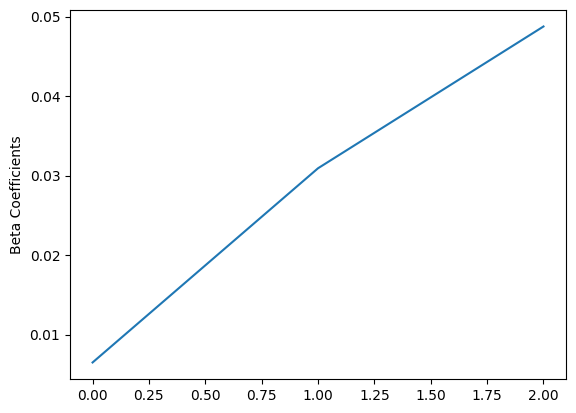

In [ ]:
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [ ]:
training_summary = lr_model.summary    # get summary (e.g. accuracy/precision/recall, objective history, total iterations) of model trained on the training set
roc = training_summary.roc.toPandas()    # get roc DF
roc

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.004329
2,0.000000,0.005291
3,0.000000,0.006253
4,0.000000,0.018759
...,...,...
289,0.339007,0.878788
290,0.343262,0.879750
291,0.343735,0.879750
292,1.000000,1.000000


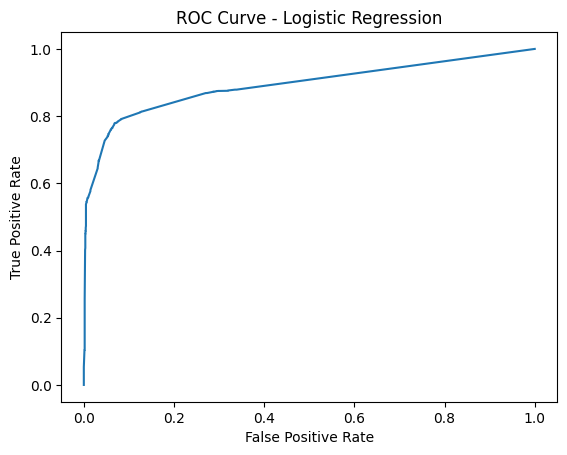

Training Set AUC = 0.8923120658345245


In [ ]:
plt.plot(roc.FPR, roc.TPR)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.show()
print(f'Training Set AUC = {training_summary.areaUnderROC}')

In [ ]:
predictions = lr_model.transform(test_df)    # transform test_df with logistic regression model
predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200032| 110262|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200032| 218377|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200055| 175557|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200055| 233815|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200065| 227397|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200106| 181408|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200166|  58283|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200191| 156250|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200263| 132785|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200279|  72878|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200360|  44

In [ ]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_predictions = predictions.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 227283|  0.0|[0.16490778696660...|[-1.6221557027166...|       1.0|
|200031|  30877|  1.0|[0.00760756602436...|[-4.8709753462192...|       1.0|
|200031|  34503|  1.0|[0.00760756602436...|[-4.8709753462192...|       1.0|
|200032| 110262|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200032| 218377|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
|200055| 175557|  0.0|[0.83416404844159...|[1.61543102768718...|       0.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
logistic_predictions = lr_model.transform(prediction_df)    # transform prediction_df with logistic regression model
logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.83416404844159...|[1.61543102768718...|       0.0|
|199810|  74139|[0.74952474895041...|[1.09607922017296...|       0.0|
|199810|   9903|[0.83416404844159...|[1.61543102768718...|       0.0|
|199810| 242681|[0.83416404844159...|[1.61543102768718...|       0.0|
|199810|  18515|[0.36603977188084...|[-0.5492442269575...|       1.0|
|199810| 105760|[0.15616093584108...|[-1.6870746786559...|       1.0|
|199812| 276940|[0.83416404844159...|[1.61543102768718...|       0.0|
|199812| 142408|[0.00103500622199...|[-6.8723122984837...|       1.0|
|199812| 130023|[0.00103500622199...|[-6.8723122984837...|       1.0|
|199812|  29189|[0.74952474895041...|[1.09607922017296...|       0.0|
|199812| 223706|[0.11959047183237...|[-1.9963140007480...|       1.0|
|199812| 211361|[0.8

In [ ]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_logistic_predictions = logistic_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_logistic_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.83416404844159...|[1.61543102768718...|       0.0|
|199810|   9903|[0.83416404844159...|[1.61543102768718...|       0.0|
|199810| 242681|[0.83416404844159...|[1.61543102768718...|       0.0|
|199810|  74139|[0.74952474895041...|[1.09607922017296...|       0.0|
|199810|  18515|[0.36603977188084...|[-0.5492442269575...|       1.0|
|199810| 105760|[0.15616093584108...|[-1.6870746786559...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
pd_sort_logistic_predictions = sort_logistic_predictions.toPandas().fillna(0.0)    # create a pandas df
pd_sort_logistic_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8341640484415942, 0.1658359515584058]","[1.6154310276871866, -1.6154310276871866]",0.0
1,199810,9903,"[0.8341640484415942, 0.1658359515584058]","[1.6154310276871866, -1.6154310276871866]",0.0
2,199810,242681,"[0.8341640484415942, 0.1658359515584058]","[1.6154310276871866, -1.6154310276871866]",0.0
3,199810,74139,"[0.7495247489504134, 0.25047525104958657]","[1.096079220172966, -1.096079220172966]",0.0
4,199810,18515,"[0.3660397718808498, 0.6339602281191502]","[-0.5492442269575208, 0.5492442269575208]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8341640484415942, 0.1658359515584058]","[1.6154310276871866, -1.6154310276871866]",0.0
119996,249010,293818,"[0.8341640484415942, 0.1658359515584058]","[1.6154310276871866, -1.6154310276871866]",0.0
119997,249010,110470,"[0.0038488625051672377, 0.9961511374948328]","[-5.556121339103813, 5.556121339103813]",1.0
119998,249010,186634,"[0.0038488625051672377, 0.9961511374948328]","[-5.556121339103813, 5.556121339103813]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_logistic_predictions.to_csv('log_reg_genre_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [ ]:
f_lr_predictions = open('log_reg_genre_predictions.csv')
f_lr_final_predictions = open('log_reg_genre_final_predictions.csv', 'w')
# Write header
f_lr_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()

# Go through each line of the predictions file
for line in f_lr_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_lr_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

f_lr_predictions.close()
f_lr_final_predictions.close()

Done! Time elapsed - 0.28 seconds.


Gradient boost , Decesion tree and random forest

In [ ]:
from pyspark.sql import SparkSession    # main entry point for DataFrame and SQL functionality
from pyspark.sql.functions import col    # for returning a column based on a given column name
from pyspark.sql.functions import lit    # for adding a new column to PySpark DataFrame
from pyspark.ml.classification import LogisticRegression    # for classification model
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler    # for preparing data for classification
from pyspark.ml.evaluation import MulticlassClassificationEvaluator    # for evaluating classification models
from pyspark.ml import Pipeline
import pandas as pd   # for data frames
import numpy as np    # for arrays
import time           # for timing cells
import matplotlib.pyplot as plt # plotting graphs

In [ ]:
# Decision Tree
from pyspark.ml.classification import DecisionTreeClassifier

spark = SparkSession.builder.appName('Decision_Tree').getOrCreate()
spark

In [ ]:
# Use file created in the earlier HW to model Decision Tree.

ratings_df = spark.read.csv('ratings.csv', header=True, inferSchema=True)
ratings_df.count()

6000

In [ ]:
ratings_columns = ratings_df.columns
pd.DataFrame(ratings_df.take(6000), columns=ratings_columns).groupby('ground_truth').count()
ratings_df.printSchema()

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: integer (nullable = true)
 |-- artist_score: integer (nullable = true)
 |-- genre_score: double (nullable = true)



In [ ]:
feature_columns = ['album_score', 'artist_score', 'genre_score']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

label_column = 'ground_truth'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

pipeline = Pipeline(stages=stages)               # initialize the pipeline
pipeline_model = pipeline.fit(ratings_df)        # fit the pipeline model
train_df = pipeline_model.transform(ratings_df)  # transform the input DF with the pipeline model

In [ ]:
selected_columns = ['label', 'features'] + ratings_columns
train_df = train_df.select(selected_columns)
train_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- ground_truth: integer (nullable = true)
 |-- album_score: integer (nullable = true)
 |-- artist_score: integer (nullable = true)
 |-- genre_score: double (nullable = true)



In [ ]:
pd.DataFrame(train_df.take(5), columns=train_df.columns).transpose()

,0,1,2,3,4
label,1.0,1.0,0.0,0.0,1.0
features,"[90.0, 50.0, 85.0]","[90.0, 0.0, 85.0]","(0.0, 0.0, 0.0)","[0.0, 0.0, 90.0]","[90.0, 50.0, 85.0]"
userID,200031,200031,200031,200031,200031
trackID,30877,8244,130183,198762,34503
ground_truth,1,1,0,0,1
album_score,90,90,0,0,90
artist_score,50,0,0,0,50
genre_score,85.0,85.0,0.0,90.0,85.0


In [ ]:
train_df, test_df = train_df.randomSplit([0.7, 0.3], seed=2021)

In [ ]:
print(f'Training Dataset Count: {train_df.count()}')
print(f'Test Dataset Count: {test_df.count()}')

Training Dataset Count: 4194
Test Dataset Count: 1806


In [ ]:
# Load and prepare prediction file

prediction_df = spark.read.csv('genre_test.txt', sep='|', inferSchema=True)    # inferSchema scans csv twice to get datatype of each column
prediction_df = prediction_df.withColumnRenamed("_c0", "userID").withColumnRenamed("_c1", "trackID").withColumnRenamed("_c2", "albumScore").withColumnRenamed("_c3", "artistScore").withColumnRenamed("_c4", "genreScore")
prediction_df.count()

120000

In [ ]:
prediction_columns = prediction_df.columns
prediction_columns

['userID', 'trackID', 'albumScore', 'artistScore', 'genreScore']

In [ ]:
prediction_df = prediction_df.withColumn('prediction', lit('0'))
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0,0,0,0,0
artistScore,0,0,0,0,70
genreScore,0.0,80.0,0.0,0.0,0.0
prediction,0,0,0,0,0


In [ ]:
prediction_df.printSchema()
feature_columns = ['albumScore', 'artistScore', 'genreScore']
stages = []
assembler_inputs = feature_columns
assembler = VectorAssembler(inputCols=assembler_inputs, outputCol='features')    # merges multiple columns into a vector column
stages += [assembler]

root
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: integer (nullable = true)
 |-- artistScore: integer (nullable = true)
 |-- genreScore: double (nullable = true)
 |-- prediction: string (nullable = false)



In [ ]:
label_column = 'prediction'
label_string_idx = StringIndexer(inputCol=label_column, outputCol='label')
stages += [label_string_idx]

prediction_pipeline = Pipeline(stages=stages)                       # initialize the pipeline
prediction_pipeline_model = prediction_pipeline.fit(prediction_df)  # fit the pipeline model
prediction_df = prediction_pipeline_model.transform(prediction_df)  # transform the input DF with the pipeline model

selected_columns = ['label', 'features'] + prediction_columns
prediction_df = prediction_df.select(selected_columns)
prediction_df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- userID: integer (nullable = true)
 |-- trackID: integer (nullable = true)
 |-- albumScore: integer (nullable = true)
 |-- artistScore: integer (nullable = true)
 |-- genreScore: double (nullable = true)



In [ ]:
pd.DataFrame(prediction_df.take(5), columns=prediction_df.columns).transpose()

,0,1,2,3,4
label,0.0,0.0,0.0,0.0,0.0
features,"(0.0, 0.0, 0.0)","[0.0, 0.0, 80.0]","(0.0, 0.0, 0.0)","(0.0, 0.0, 0.0)","[0.0, 70.0, 0.0]"
userID,199810,199810,199810,199810,199810
trackID,208019,74139,9903,242681,18515
albumScore,0,0,0,0,0
artistScore,0,0,0,0,70
genreScore,0.0,80.0,0.0,0.0,0.0


In [ ]:
# Decision Tree

start_time = time.time()

dt = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=20)
dt_model = dt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

Done! Time elapsed - 2.35 seconds.


In [ ]:
predictions_dt = dt_model.transform(test_df)
evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_dt)    # evaluate decision tree model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Test Error = 15.12%


In [ ]:
sort_predictions_dt = predictions_dt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_dt.show(6)

+------+-------+-----+--------------------+--------------+----------+
|userID|trackID|label|         probability| rawPrediction|prediction|
+------+-------+-----+--------------------+--------------+----------+
|200031| 227283|  0.0|[0.19010416666666...|  [73.0,311.0]|       1.0|
|200031|  30877|  1.0|[0.02325581395348...|   [3.0,126.0]|       1.0|
|200031|  34503|  1.0|[0.02325581395348...|   [3.0,126.0]|       1.0|
|200032| 110262|  0.0|[0.84828807556080...|[1437.0,257.0]|       0.0|
|200032| 218377|  0.0|[0.84828807556080...|[1437.0,257.0]|       0.0|
|200055| 175557|  0.0|[0.84828807556080...|[1437.0,257.0]|       0.0|
+------+-------+-----+--------------------+--------------+----------+
only showing top 6 rows



In [ ]:
dt_predictions = dt_model.transform(prediction_df)    # transform prediction_df with decision tree model
dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|  74139|[0.72456575682382...| [292.0,111.0]|       0.0|
|199810|   9903|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810| 242681|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|  18515|   [0.28125,0.71875]|    [9.0,23.0]|       1.0|
|199810| 105760|[0.19010416666666...|  [73.0,311.0]|       1.0|
|199812| 276940|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199812| 142408|[0.00278940027894...|   [2.0,715.0]|       1.0|
|199812| 130023|[0.00278940027894...|   [2.0,715.0]|       1.0|
|199812|  29189|[0.72456575682382...| [292.0,111.0]|       0.0|
|199812| 223706|[0.13888888888888...|    [5.0,31.0]|       1.0|
|199812| 211361|[0.84828807556080...|[1437.0,257.0]|       0.0|
+------+-------+--------------------+---

In [ ]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_dt_predictions = dt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_dt_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|   9903|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810| 242681|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|  74139|[0.72456575682382...| [292.0,111.0]|       0.0|
|199810|  18515|   [0.28125,0.71875]|    [9.0,23.0]|       1.0|
|199810| 105760|[0.19010416666666...|  [73.0,311.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [ ]:
pd_sort_dt_predictions = sort_dt_predictions.toPandas().fillna(0.0)    # create pandas df
pd_sort_dt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
1,199810,9903,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
2,199810,242681,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
3,199810,74139,"[0.7245657568238213, 0.27543424317617865]","[292.0, 111.0]",0.0
4,199810,18515,"[0.28125, 0.71875]","[9.0, 23.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
119996,249010,293818,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
119997,249010,110470,"[0.002789400278940028, 0.99721059972106]","[2.0, 715.0]",1.0
119998,249010,186634,"[0.002789400278940028, 0.99721059972106]","[2.0, 715.0]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_dt_predictions.to_csv('decision_tree_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without header)

In [ ]:
f_dt_predictions = open('decision_tree_predictions.csv')
f_dt_final_predictions = open('decision_tree_final_predictions.csv', 'w')

In [ ]:
# Write header
f_dt_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()

# Go through each line of the predictions file
for line in f_dt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_dt_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

f_dt_predictions.close()
f_dt_final_predictions.close()

Done! Time elapsed - 0.24 seconds.


In [ ]:
# Random Forest

from pyspark.ml.classification import RandomForestClassifier

start_time = time.time()

rf = RandomForestClassifier(featuresCol='features', labelCol='label')
rf_model = rf.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

predictions_rf = rf_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_rf)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Done! Time elapsed - 1.94 seconds.
Test Error = 14.45%


In [ ]:
sort_predictions_rf = predictions_rf.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_rf.show(6)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 227283|  0.0|[0.17245143842359...|[3.44902876847180...|       1.0|
|200031|  30877|  1.0|[0.02518519703541...|[0.50370394070838...|       1.0|
|200031|  34503|  1.0|[0.02518519703541...|[0.50370394070838...|       1.0|
|200032| 110262|  0.0|[0.83620696068304...|[16.724139213661,...|       0.0|
|200032| 218377|  0.0|[0.83620696068304...|[16.724139213661,...|       0.0|
|200055| 175557|  0.0|[0.83620696068304...|[16.724139213661,...|       0.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
rf_predictions = dt_model.transform(prediction_df)    # transform prediction_df with random forest model
rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|  74139|[0.72456575682382...| [292.0,111.0]|       0.0|
|199810|   9903|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810| 242681|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|  18515|   [0.28125,0.71875]|    [9.0,23.0]|       1.0|
|199810| 105760|[0.19010416666666...|  [73.0,311.0]|       1.0|
|199812| 276940|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199812| 142408|[0.00278940027894...|   [2.0,715.0]|       1.0|
|199812| 130023|[0.00278940027894...|   [2.0,715.0]|       1.0|
|199812|  29189|[0.72456575682382...| [292.0,111.0]|       0.0|
|199812| 223706|[0.13888888888888...|    [5.0,31.0]|       1.0|
|199812| 211361|[0.84828807556080...|[1437.0,257.0]|       0.0|
+------+-------+--------------------+---

In [ ]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_rf_predictions = rf_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_rf_predictions.show(6)

+------+-------+--------------------+--------------+----------+
|userID|trackID|         probability| rawPrediction|prediction|
+------+-------+--------------------+--------------+----------+
|199810| 208019|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|   9903|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810| 242681|[0.84828807556080...|[1437.0,257.0]|       0.0|
|199810|  74139|[0.72456575682382...| [292.0,111.0]|       0.0|
|199810|  18515|   [0.28125,0.71875]|    [9.0,23.0]|       1.0|
|199810| 105760|[0.19010416666666...|  [73.0,311.0]|       1.0|
+------+-------+--------------------+--------------+----------+
only showing top 6 rows



In [ ]:
pd_sort_rf_predictions = sort_rf_predictions.toPandas().fillna(0.0)    # create pandas df
pd_sort_rf_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
1,199810,9903,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
2,199810,242681,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
3,199810,74139,"[0.7245657568238213, 0.27543424317617865]","[292.0, 111.0]",0.0
4,199810,18515,"[0.28125, 0.71875]","[9.0, 23.0]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
119996,249010,293818,"[0.8482880755608029, 0.15171192443919718]","[1437.0, 257.0]",0.0
119997,249010,110470,"[0.002789400278940028, 0.99721059972106]","[2.0, 715.0]",1.0
119998,249010,186634,"[0.002789400278940028, 0.99721059972106]","[2.0, 715.0]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_rf_predictions.to_csv('random_forest_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [ ]:
f_rf_predictions = open('random_forest_predictions.csv')
f_rf_final_predictions = open('random_forest_final_predictions.csv', 'w')

In [ ]:
# Write header
f_rf_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()

# Go through each line of the predictions file
for line in f_rf_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_rf_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

f_rf_predictions.close()
f_rf_final_predictions.close()

Done! Time elapsed - 0.51 seconds.


In [ ]:
# Gradient Boosted Tree

from pyspark.ml.classification import GBTClassifier

start_time = time.time()

gbt = GBTClassifier(maxIter=100)
gbt_model = gbt.fit(train_df)

end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

predictions_gbt = gbt_model.transform(test_df)

evaluator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')    # initialize an Evaluator for Multiclass Classification
accuracy = evaluator.evaluate(predictions_gbt)    # evaluate random forest model on predictions
print(f'Test Error = {1.0 - accuracy:.2%}')

Done! Time elapsed - 39.01 seconds.
Test Error = 15.01%


In [ ]:
sort_predictions_gbt = predictions_gbt.select('userID', 'trackID', 'label', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_predictions_gbt.show(6)

gbt_predictions = gbt_model.transform(prediction_df)    # transform prediction_df with gradient-boosted tree model
gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').show(12)

+------+-------+-----+--------------------+--------------------+----------+
|userID|trackID|label|         probability|       rawPrediction|prediction|
+------+-------+-----+--------------------+--------------------+----------+
|200031| 227283|  0.0|[0.21518543762805...|[-0.6469736533077...|       1.0|
|200031|  30877|  1.0|[0.01421111170587...|[-2.1197090246712...|       1.0|
|200031|  34503|  1.0|[0.01421111170587...|[-2.1197090246712...|       1.0|
|200032| 110262|  0.0|[0.84760313000509...|[0.85796220711124...|       0.0|
|200032| 218377|  0.0|[0.84760313000509...|[0.85796220711124...|       0.0|
|200055| 175557|  0.0|[0.84760313000509...|[0.85796220711124...|       0.0|
+------+-------+-----+--------------------+--------------------+----------+
only showing top 6 rows

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|1998

In [ ]:
# col('userID').asc() sort the user ascending
# col('probability').desc() sort the probability descending (from large to small)
sort_gbt_predictions = gbt_predictions.select('userID', 'trackID', 'probability', 'rawPrediction', 'prediction').sort(col('userID').asc(), col('probability').desc())
sort_gbt_predictions.show(6)

+------+-------+--------------------+--------------------+----------+
|userID|trackID|         probability|       rawPrediction|prediction|
+------+-------+--------------------+--------------------+----------+
|199810| 208019|[0.84760313000509...|[0.85796220711124...|       0.0|
|199810|   9903|[0.84760313000509...|[0.85796220711124...|       0.0|
|199810| 242681|[0.84760313000509...|[0.85796220711124...|       0.0|
|199810|  74139|[0.72350749410959...|[0.48096359351340...|       0.0|
|199810|  18515|[0.27996744400564...|[-0.4723115513229...|       1.0|
|199810| 105760|[0.20031666336396...|[-0.6921581944293...|       1.0|
+------+-------+--------------------+--------------------+----------+
only showing top 6 rows



In [ ]:
pd_sort_gbt_predictions = sort_gbt_predictions.toPandas().fillna(0.0)    # create pandas df

In [ ]:
pd_sort_gbt_predictions

,userID,trackID,probability,rawPrediction,prediction
0,199810,208019,"[0.8476031300050955, 0.15239686999490454]","[0.8579622071112453, -0.8579622071112453]",0.0
1,199810,9903,"[0.8476031300050955, 0.15239686999490454]","[0.8579622071112453, -0.8579622071112453]",0.0
2,199810,242681,"[0.8476031300050955, 0.15239686999490454]","[0.8579622071112453, -0.8579622071112453]",0.0
3,199810,74139,"[0.7235074941095933, 0.27649250589040675]","[0.48096359351340884, -0.48096359351340884]",0.0
4,199810,18515,"[0.2799674440056487, 0.7200325559943512]","[-0.47231155132293595, 0.47231155132293595]",1.0
...,...,...,...,...,...
119995,249010,86104,"[0.8476031300050955, 0.15239686999490454]","[0.8579622071112453, -0.8579622071112453]",0.0
119996,249010,293818,"[0.8476031300050955, 0.15239686999490454]","[0.8579622071112453, -0.8579622071112453]",0.0
119997,249010,110470,"[0.014470529025492772, 0.9855294709745073]","[-2.1105324653015916, 2.1105324653015916]",1.0
119998,249010,186634,"[0.014470529025492772, 0.9855294709745073]","[-2.1105324653015916, 2.1105324653015916]",1.0


In [ ]:
columns_to_write = ['userID', 'trackID']
pd_sort_gbt_predictions.to_csv('grad_boost_predictions.csv', index=False, header=None, columns=columns_to_write)    # write to csv (without headers)

In [ ]:
f_gbt_predictions = open('grad_boost_predictions.csv')
f_gbt_final_predictions = open('grad_boost_final_predictions.csv', 'w')

In [ ]:
# Write header
f_gbt_final_predictions.write('TrackID,Predictor\n')

18

In [ ]:
# Initialize some values
last_user_id = -1
track_id_out_vec = [0] * 6

start_time = time.time()

# Go through each line of the predictions file
for line in f_gbt_predictions:
    arr_out = line.strip().split(',')    # remove any spaces/new lines and create list
    user_id_out = arr_out[0]             # set user
    track_id_out = arr_out[1]            # set track

    if user_id_out != last_user_id:             # if new user reached
        i = 0                                   # reset i

    track_id_out_vec[i] = track_id_out          # add trackID to trackID array

    i = i + 1                    # increment i
    last_user_id = user_id_out   # set last_user_id as current userID

    if i == 6:                               # if last entry for current user reached
        # Here we set the predictions
        predictions = np.ones(shape=(6)) # initialize numpy array for predictions
        for index in range(0, 3):
            predictions[index] = 0           # set first 3 values in array to 0 (other 3 are 1)

        # Here we write to the final predictions file for the 6 track predictions for the current user
        for ii in range(0, 6):
            out_str = str(user_id_out) + '_' + str(track_id_out_vec[ii]) + ',' + str(int(predictions[ii]))
            f_gbt_final_predictions.write(out_str + '\n')


end_time = time.time()
elapsed_time = end_time - start_time
print(f'Done! Time elapsed - {elapsed_time:.2f} seconds.')

f_gbt_predictions.close()
f_gbt_final_predictions.close()

Done! Time elapsed - 0.47 seconds.
